<a href="https://colab.research.google.com/github/Zrce/Google-Discover-Data-Merger/blob/main/Google_Discover_Data_Merger_(waiting_for_the_Discover_API)_Bugs%2C_questions_tobias_willmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Discover Data Merger

Bugs, questions https://twitter.com/tobias_willmann / https://www.linkedin.com/in/tobiaswillmann/

This is a starting point to combine Google Discover CSV exports. This is useful for:


---


*   Not be limited by the 1000 rows of data in the Discover export if you want to analyze e.g. a one month date period. **Export for example every day of a month and combine the data with this script.**
*   Quickly load discover data into Python Pandas
*   Work with data older than 16 months (if you saved the data)



In [ ]:
from zipfile import ZipFile
import pandas as pd
from os import listdir
from os.path import isfile, join

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Please check. You need first: 
*   A folder structure "/Google Discover Data Merger/data/" in your Google Drive
*   **English Google Discover CSV exports** as zip files uploaded *into* this folder

Edit *foldername* variable if needed


In [ ]:
foldername = '/content/drive/MyDrive/Google Discover Data Merger/data/'
df = pd.DataFrame({'Top pages': [], 'Clicks': [], 'Impressions': [], 'CTR': []})

# Add the folder with zipped discver csv exports 
for file in listdir(foldername):
    if file.endswith(".zip"): 
        #print(file)
        # Open file
        file_name = foldername+file
        with ZipFile(file_name) as zip:
            date = 0
            # Get the dates / date 
            try:
              with zip.open('Dates.csv') as myZip:
                  df_date = pd.read_csv(myZip)
                  # Just one date 
                  if len(df_date.index) == 1: 
                      date = df_date.iloc[0]['Date']
                  # Multiple dates
                  else: 
                      date = df_date.iloc[len(df_date.index)-1]['Date'] + " - " + df_date.iloc[0]['Date']
            except Error:
              print("Having problems with reading Dates.csv. Get an englisch export as CSV from Google Discover.")
              
            # Open pages 
            try:
              with zip.open('Pages.csv') as myZip:
                  df_new = pd.read_csv(myZip)
                  df_new.insert(0, 'Date', date)
                  df = pd.concat([df,df_new])
            except Error:
              print("Having problems with reading Pages.csv. Get an englisch export as CSV from Google Discover.")
               

# All the data just concatinated + with a Date column
Results will look like this 

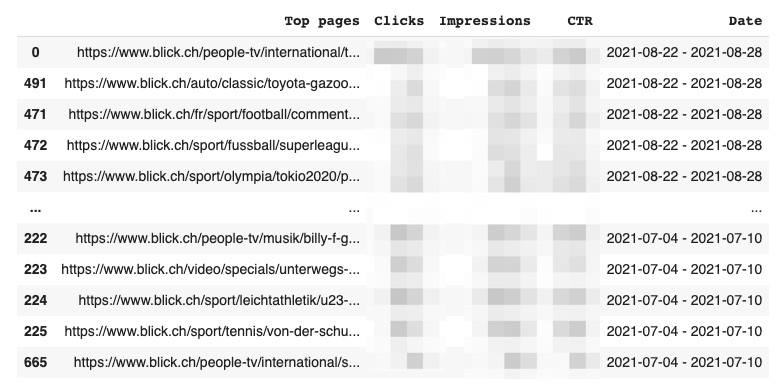

In [ ]:
df = df.sort_values('Date', ascending=False)
df

# Pivot with all data grouped by URL
Results 2: Sum of Clicks + Impressions for every URL. Count of appearences in multiple files/dates

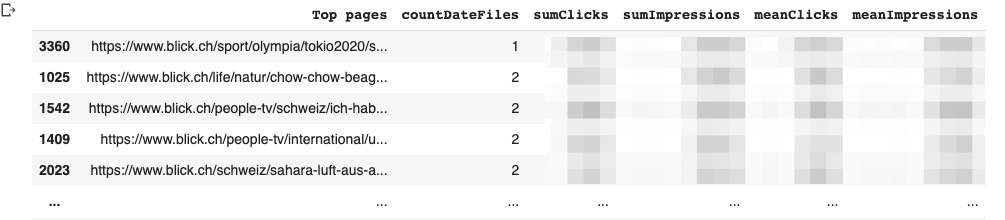


In [ ]:
dfPivotPages = pd.pivot_table(df,index='Top pages', values=['Clicks','Impressions'], aggfunc=['count','sum', 'mean'])
dfPivotPages = dfPivotPages.round(0).astype(int)
dfPivotPages.fillna(0, inplace=True)
dfPivotPages.reset_index(inplace=True, col_level=1)
dfPivotPages.columns = [f'{i}{j}' for i, j in dfPivotPages.columns]
dfPivotPages = dfPivotPages.rename(columns = {'countClicks': 'countDateFiles'}, inplace = False)
dfPivotPages = dfPivotPages.drop("countImpressions",1)
dfPivotPages = dfPivotPages.sort_values('sumImpressions', ascending=False)
dfPivotPages

# Export to Google Sheet

In [ ]:
#Export to Google Sheets / Part 1 Auth
!pip install --upgrade --quiet gspread
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
#Export to Google Sheets / Part 2 Export
from gspread_dataframe import get_as_dataframe, set_with_dataframe

sh = gc.open('Google Discover Data Merger')

try: 
  worksheetPivot = sh.worksheet('Pivot URL')
  sh.del_worksheet(worksheetPivot)
  sh.add_worksheet(title='Pivot URL', rows="100000", cols="6")
  set_with_dataframe(worksheetPivot, dfPivotPages)
except:
  print("Error writing Pivot URL")

try: 
  worksheetAll = sh.worksheet('All Data')
  sh.del_worksheet(worksheetAll)
  sh.add_worksheet(title='All Data', rows="100000", cols="5")
  set_with_dataframe(worksheetAll, df)
except:
  print("Error writing All Data")
